### Import Packages

In [1]:
import pandas as pd
import numpy as np
import os
from PIL import Image
from tqdm import tqdm
import torch
from transformers import ViTImageProcessor, ViTForImageClassification, ViTConfig
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from datasets import Dataset

/Users/kyleandrecastro/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(
/Users/kyleandrecastro/Library/Python/3.9/lib/python/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Image and Labels Loading and Matching

In [2]:
# Load the Data from CSV
csv_file = "15_clean_MovieGenre.csv"  # Path to your CSV file
df = pd.read_csv(csv_file)

#list of labels
binarized_columns = ['Action', 'Adventure', 'Animation', 'Biography', 'Comedy', 'Crime', 'Documentary', 
                     'Drama', 'Family', 'Fantasy', 'Horror', 'Romance', 'Thriller']

In [3]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, processor):
        self.images = images
        self.labels = labels.astype(np.float32)
        self.processor = processor  # Store the processor as an attribute

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]

        # Process image using the provided processor
        inputs = self.processor(images=image, return_tensors="pt")
        processed_image = inputs.pixel_values.squeeze(0)  # Remove batch dimension

        return {"pixel_values": processed_image, "labels": label}

In [4]:
image_folder = "downloaded_images" #sample_images for developing, downloaded_images for final
images = []
labels = []
batch_size = 128  

# Load images and labels in batches
num_batches = len(df) // batch_size + 1

for batch_num in tqdm(range(num_batches)):
    start_idx = batch_num * batch_size
    end_idx = min((batch_num + 1) * batch_size, len(df))
    
    batch_df = df.iloc[start_idx:end_idx]
    batch_images = []
    batch_labels = []
    
    for index, row in batch_df.iterrows():
        filename = str(row.iloc[0]) + ".jpg"  # filenames match the imdbIDs
        label = [int(row[column]) for column in binarized_columns]  # Extract binarized labels for each genre

        image_path = os.path.join(image_folder, filename)
        try:
            image = Image.open(image_path)  # Open image using PIL
            image = image.convert("RGB")  # Convert image to RGB mode if necessary
            image_array = np.array(image)  # Convert PIL Image to numpy array
            batch_images.append(image_array)
            batch_labels.append(label)
        except Exception as e:
            pass
    # Concatenate the batches of images and labels
    if batch_images:
        images.append(np.array(batch_images))
        labels.append(np.array(batch_labels))

# Concatenate all batches into single numpy arrays
if images:
    images = np.concatenate(images, axis=0)
    labels = np.concatenate(labels, axis=0)

100%|██████████| 258/258 [00:15<00:00, 16.23it/s]


### Sample Posters

Images shape: (32899, 268, 182, 3)
Labels shape: (32899, 13)


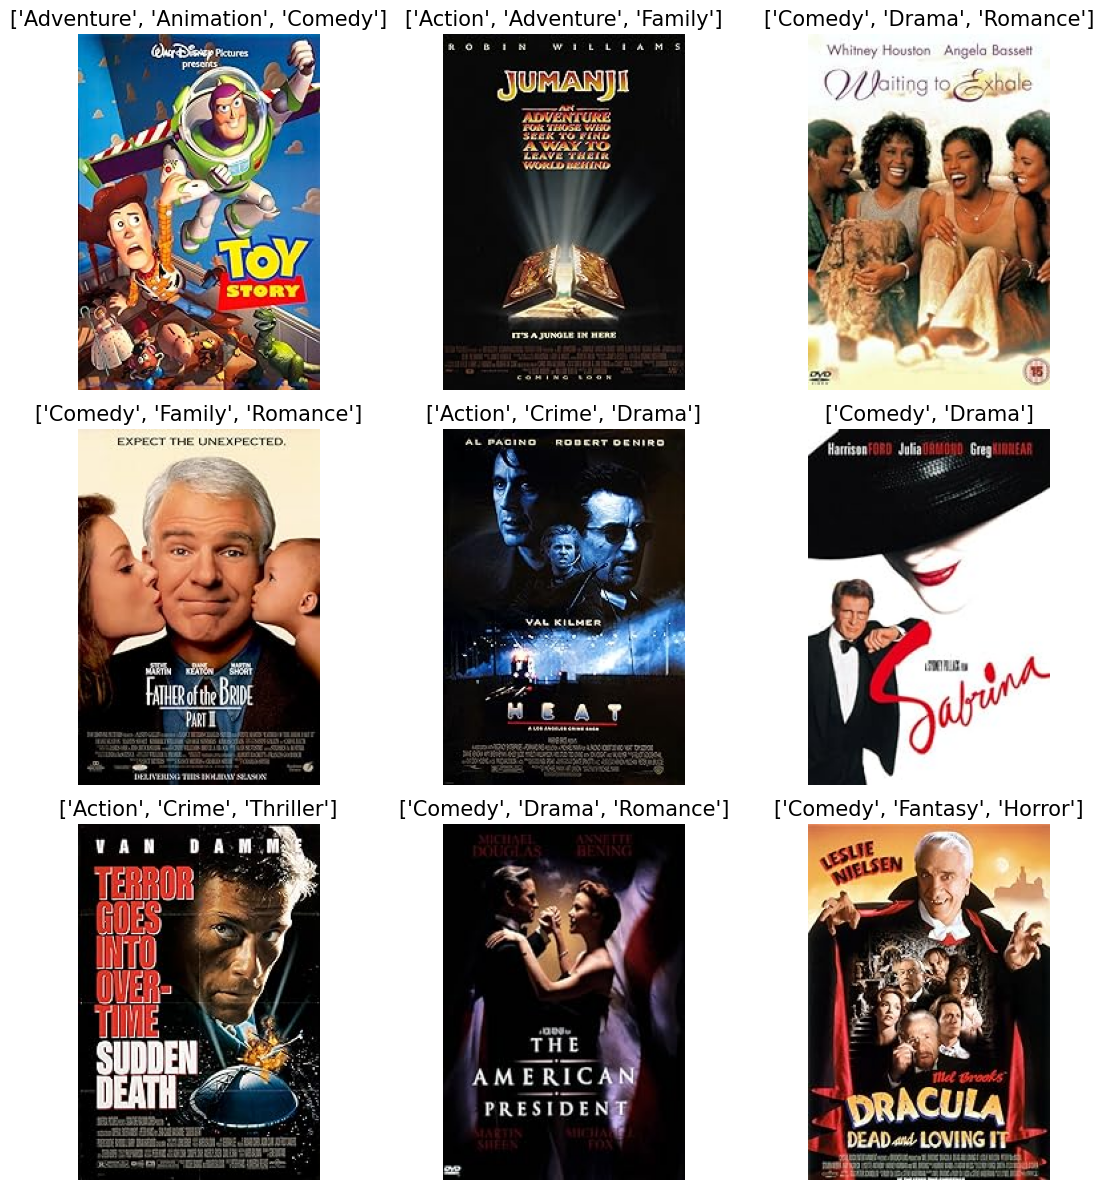

In [5]:
# Print the shapes of the loaded data
print("Images shape:", images.shape)
print("Labels shape:", labels.shape)

# Display sample images
plt.figure(figsize=(12, 12))
for i in range(9):
	ax = plt.subplot(3, 3, i + 1)
	plt.imshow(images[i])
	plt.axis('off')
	plt.title([column for column, label in zip(binarized_columns, labels[i]) if label == 1], fontsize=15)
plt.tight_layout()
plt.show()

### Preprocessing

In [6]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=0.1, random_state=42)

# Print the shapes of the split datasets
print("Training images shape:", X_train.shape)
print("Training labels shape:", y_train.shape)

print("Testing images shape:", X_test.shape)
print("Testing labels shape:", y_test.shape)

Training images shape: (29609, 268, 182, 3)
Training labels shape: (29609, 13)
Testing images shape: (3290, 268, 182, 3)
Testing labels shape: (3290, 13)


In [7]:
# Normalize pixel values to the range [0, 1] and convert to float32
X_test = (X_test / 255.0)

X_test = np.transpose(X_test, (0, 3, 1, 2))

In [8]:
# Ensure labels are int64
y_test = y_test.astype(np.int64)

In [9]:
test_data = {"pixel_values": X_test, "labels": y_test}
test_dataset = Dataset.from_dict(test_data)

### Modeling

In [10]:
# Load the default ViT model configuration
vit_config = ViTConfig.from_pretrained('google/vit-base-patch16-224-in21k')

# Update the image size in the configuration
vit_config = ViTConfig(
    image_size=(268, 182),
    problem_type="multi_label_classification",
	num_labels=len(binarized_columns),
    is_classifier=True,
    classifier_activation="sigmoid"
)

/Users/kyleandrecastro/Library/Python/3.9/lib/python/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [11]:
# Model Specification
processor = ViTImageProcessor.from_pretrained('google/vit-base-patch16-224-in21k')
model = ViTForImageClassification.from_pretrained('google/vit-base-patch16-224-in21k', config=vit_config, ignore_mismatched_sizes=True)

#utilize cuda if GPU is available
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)
model = model.to(device)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized because the shapes did not match:
- embeddings.position_embeddings: found shape torch.Size([1, 197, 768]) in the checkpoint and torch.Size([1, 177, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using device: cpu


### Testing

In [12]:
# Ensure processor has the correct image size
processor.size = (268, 182)  

# Perform inference
model.eval()
predicted_probabilities = []

for i in range(0, len(X_test), batch_size):
    # Process batch inputs
    batch_images = X_test[i:i+batch_size]
    processed_images = []
    for img in batch_images:
        # Convert float32 to uint8 and transpose if necessary
        img_uint8 = (img * 255).astype(np.uint8)
        img_rgb = np.transpose(img_uint8, (1, 2, 0))  # Transpose to (height, width, channels)
        processed_images.append(img_rgb)
    
    # Convert numpy arrays to lists of PIL images and process
    batch_inputs = processor(images=[Image.fromarray(img) for img in processed_images], return_tensors="pt") 
    batch_inputs = {k: v.to(device) for k, v in batch_inputs.items()}
    
    with torch.no_grad():
        # Forward pass
        outputs = model(**batch_inputs)
    
    # Get the predicted logits
    logits = outputs.logits
    
    # Convert logits to probabilities using sigmoid
    probabilities = torch.sigmoid(logits)
    
    # Append predicted probabilities for this batch
    predicted_probabilities.append(probabilities.cpu().numpy())

# Concatenate predicted probabilities for all batches
predicted_probabilities = np.concatenate(predicted_probabilities, axis=0)

In [13]:
# Convert lists to NumPy arrays
y_test_np = np.array(y_test)
predicted_probabilities_np = np.array(predicted_probabilities)

# Ensure that the arrays have the appropriate shape
y_test_np = np.vstack([np.array(y) for y in y_test_np])

# Define the threshold for binary classification
threshold = 0.5

# Threshold predicted probabilities to obtain binary predictions
predicted_labels_np = (predicted_probabilities_np > threshold).astype(int)

### Evaluation

In [14]:
# Initialize lists to store F1 scores and accuracies for each label
f1_scores = []
accuracies = []
predicted_binary_labels = (predicted_probabilities > threshold).astype(int)

# Iterate over each label
for i, label in enumerate(binarized_columns):
    # Calculate F1 score
    f1 = f1_score(y_test_np[:, i], predicted_labels_np[:, i], average='binary')
    f1_scores.append(f1)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test[:, i], predicted_binary_labels[:, i])
    accuracies.append(accuracy)

# Calculate overall F1 score using micro and weighted averages
f1_micro = f1_score(y_test_np, predicted_labels_np, average='micro')
f1_weighted = f1_score(y_test_np, predicted_labels_np, average='weighted')

# Create DataFrame to display label-wise metrics
data = {
    "Label": binarized_columns,
    "F1 Score": f1_scores,
    "Accuracy": accuracies
}

df = pd.DataFrame(data)
print(df)

# Print the overall F1 scores
print("\nMicro-averaged F1 score:", f1_micro)
print("Weighted-averaged F1 score:", f1_weighted)

# Compute average F1 score per label
avg_f1_score = np.mean(f1_scores)
print("Average F1 score (per label):", avg_f1_score)

# Compute average accuracy
average_accuracy = sum(accuracies) / len(accuracies)
print("Average accuracy:", average_accuracy)

          Label  F1 Score  Accuracy
0        Action  0.138324  0.678116
1     Adventure  0.150479  0.622492
2     Animation  0.100215  0.617933
3     Biography  0.087930  0.331611
4        Comedy  0.407950  0.483891
5         Crime  0.220523  0.256535
6   Documentary  0.163985  0.336778
7         Drama  0.401067  0.522492
8        Family  0.102763  0.368389
9       Fantasy  0.085686  0.429179
10       Horror  0.057637  0.801216
11      Romance  0.253817  0.286930
12     Thriller  0.167571  0.580243

Micro-averaged F1 score: 0.20336895489947474
Weighted-averaged F1 score: 0.26710761201806377
Average F1 score (per label): 0.17984204852381053
Average accuracy: 0.4858311900865093


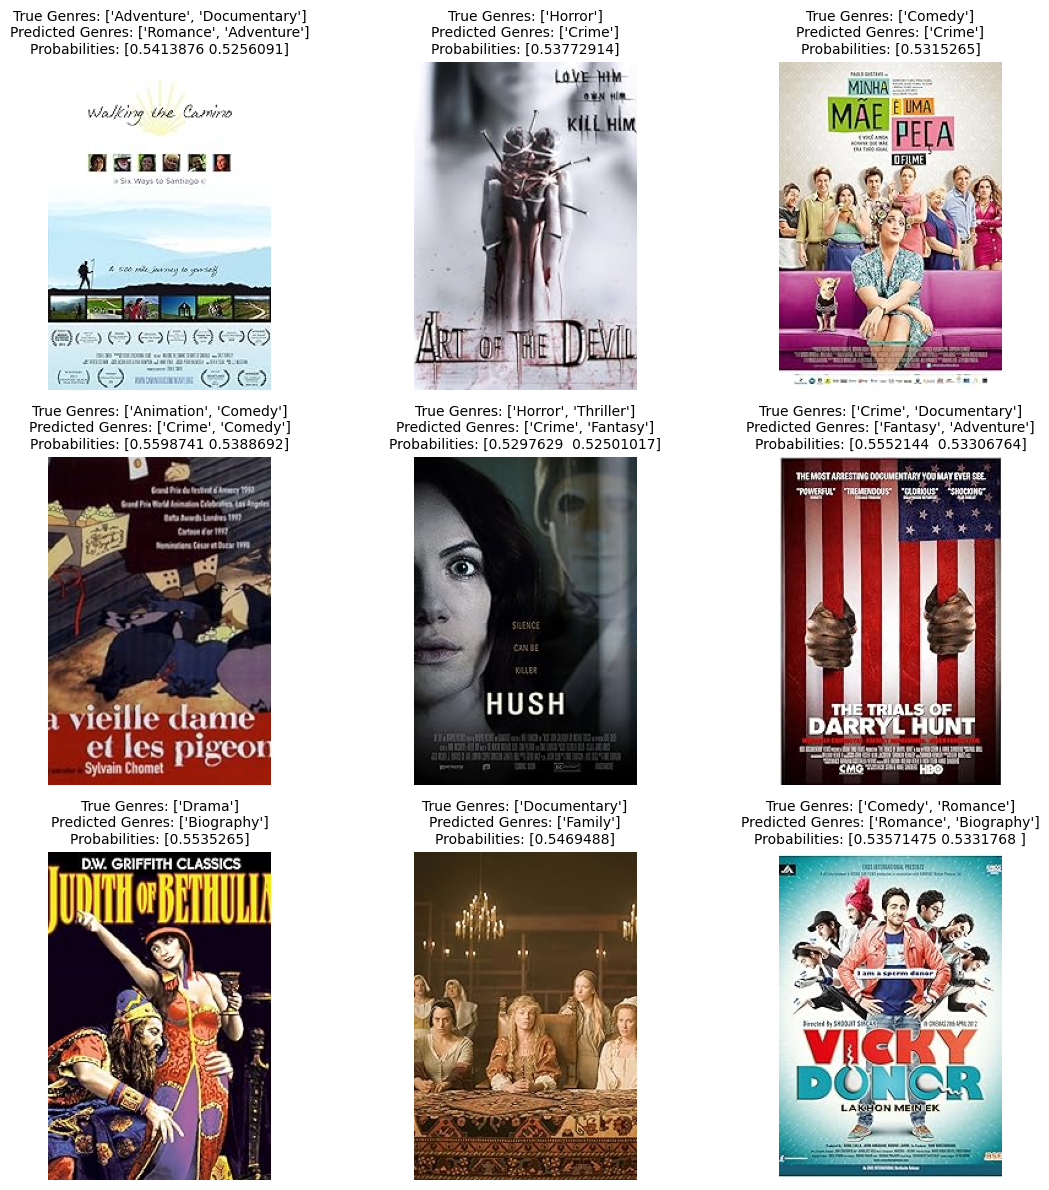

In [15]:
def display(X_test, y_test, predicted_probabilities, binarized_columns, threshold=0.5):
    fig, axes = plt.subplots(3, 3, figsize=(12, 12))

    for idx, ax in enumerate(axes.flat):
        if idx < len(X_test):
            poster = X_test[idx].transpose(1, 2, 0)  # Transpose back to (height, width, channels)
            true_labels = [binarized_columns[i] for i, label in enumerate(y_test[idx]) if label == 1]
            predicted_genre_probabilities = predicted_probabilities[idx]

            # Sort predicted probabilities and select labels based on the number of true labels
            num_true_labels = len(true_labels)
            top_predicted_idx = np.argsort(predicted_genre_probabilities)[::-1][:num_true_labels]
            predicted_genre_labels = [binarized_columns[i] for i in top_predicted_idx]
            top_predicted_probabilities = predicted_genre_probabilities[top_predicted_idx]

            ax.imshow(poster)
            ax.set_title(f"True Genres: {true_labels}\nPredicted Genres: {predicted_genre_labels}\nProbabilities: {top_predicted_probabilities}", fontsize=10)
            ax.axis('off')
        else:
            ax.axis('off')  # Hide empty subplots
        
    plt.tight_layout()
    plt.show()

display(X_test, y_test, predicted_probabilities, binarized_columns)
